In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
! pip install --upgrade pip
! pip install seaborn
! pip install scikit-image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 36.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# loading dataset
data = []
labels = []
classes = 43
cur_path = '../input/gtsrb-german-traffic-sign/Train'

for i in os.listdir(cur_path):
    dir = cur_path + '/' + i
    for j in os.listdir(dir):
        img_path = dir+'/'+j
        img = cv2.imread(img_path,-1)
        img = cv2.resize(img, (30,30), interpolation = cv2.INTER_NEAREST)
        data.append(img)
        labels.append(i)
        
x_train = np.array(data)
x_train = x_train / 255
y_train = np.array(labels).astype(np.float)


In [4]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

class_names = np.unique(y_train)

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(31367, 30, 30, 3) (31367,)
(7842, 30, 30, 3) (7842,)


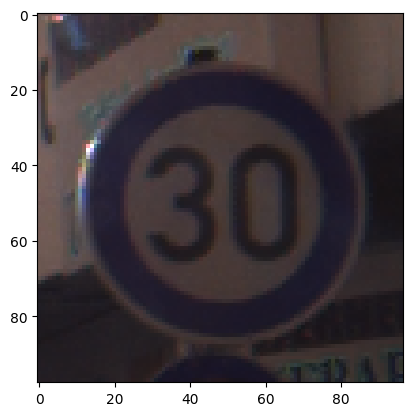

In [5]:
i_path = '../input/gtsrb-german-traffic-sign/Train/1/00001_00072_00027.png'
plt.imshow(cv2.imread(i_path, -1))

In [6]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *


model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5), activation = 'relu', 
                 input_shape = (30, 30, 3), data_format = 'channels_last',
                 kernel_regularizer = regularizers.l1_l2(l1=1e-4, l2=1e-3)))
model.add(BatchNormalization())

# replace maxpooling with conv2d
model.add(Conv2D(filters = 64, kernel_size = (5,5), padding = "same", strides = (2, 2),
                kernel_regularizer = regularizers.l1_l2(l1=1e-4, l2=1e-3)))
model.add(BatchNormalization())

model.add(Conv2D(filters = 128, kernel_size = (5,5), activation = 'relu' ,
                 kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# replace maxpooling with conv2d
model.add(Conv2D(filters = 128, kernel_size = (5,5), padding = "same",
                 kernel_regularizer = regularizers.l1_l2(l1=1e-4, l2=1e-3), strides = (2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(1024, activation = 'relu',  kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3)))
model.add(Dropout(0.4))
model.add(Dense(256, activation = 'relu',  kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3)))
model.add(Dropout(0.5))
model.add(Dense(43, activation = 'softmax',  kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3)))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        2432      
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 13, 13, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         204928    
                                                                 
 batch_normalization_2 (Batc  (None, 9, 9, 128)        5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 16.6 MB/s eta 0:00:00


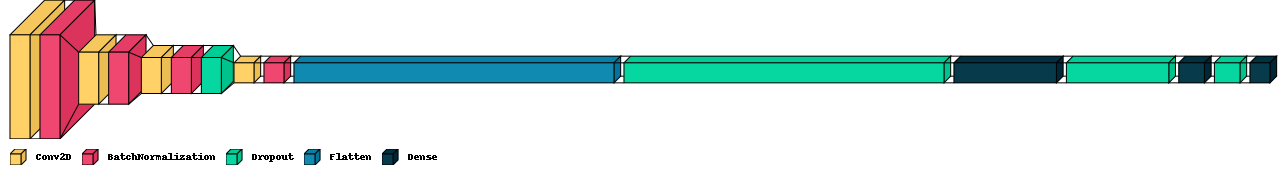

In [7]:
from PIL import Image, ImageDraw, ImageFont
!pip install visualkeras
import visualkeras
visualkeras.layered_view(model,legend=True)

In [8]:
import timeit
callback = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',factor=1e-1, patience=8, verbose=1, min_lr = 2e-6)
opt = Adam(learning_rate = 1e-3)
model.compile(optimizer = opt,
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])
startTime = timeit.default_timer()
history = model.fit(x_train ,y_train,  batch_size = 128, 
         epochs=200, validation_data = (x_valid, y_valid),
          callbacks=[callback, reduce_lr], shuffle = True)
elapsedTime = timeit.default_timer() - startTime
print("Time taken for the Network to train : ",elapsedTime)


Epoch 1/200


2023-11-01 06:20:54.015114: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


246/246 [==============================] - 20s 21ms/step - loss: 9.1802 - accuracy: 0.7074 - val_loss: 8.5519 - val_accuracy: 0.1006 - lr: 0.0010
Epoch 2/200
246/246 [==============================] - 4s 17ms/step - loss: 3.9662 - accuracy: 0.9059 - val_loss: 4.4662 - val_accuracy: 0.5608 - lr: 0.0010
Epoch 3/200
246/246 [==============================] - 4s 17ms/step - loss: 2.4906 - accuracy: 0.9302 - val_loss: 2.4256 - val_accuracy: 0.9229 - lr: 0.0010
Epoch 4/200
246/246 [==============================] - 4s 17ms/step - loss: 1.9770 - accuracy: 0.9415 - val_loss: 1.6179 - val_accuracy: 0.9554 - lr: 0.0010
Epoch 5/200
246/246 [==============================] - 4s 17ms/step - loss: 1.6295 - accuracy: 0.9463 - val_loss: 1.5807 - val_accuracy: 0.9579 - lr: 0.0010
Epoch 6/200
246/246 [==============================] - 4s 17ms/step - loss: 1.4944 - accuracy: 0.9511 - val_loss: 1.4441 - val_accuracy: 0.9680 - lr: 0.0010
Epoch 7/200
246/246 [==============================] - 4s 17ms/step -

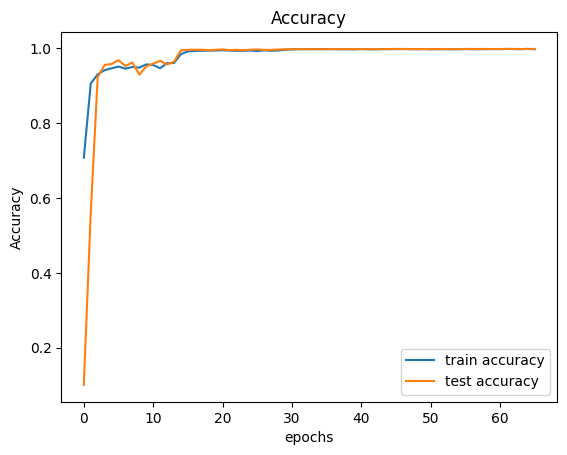

In [9]:
plt.figure(0)
plt.plot(history.history['accuracy'], label= 'train accuracy')
plt.plot(history.history['val_accuracy'], label= 'test accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()

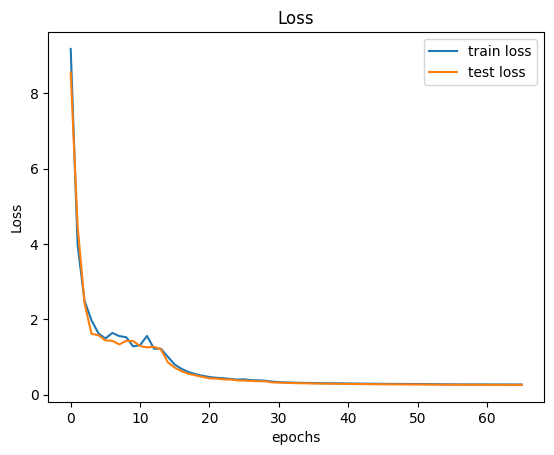

In [10]:
plt.figure(0)
plt.plot(history.history['loss'], label= 'train loss')
plt.plot(history.history['val_loss'], label= 'test loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()

In [11]:
test = pd.read_csv('../input/gtsrb-german-traffic-sign/Test.csv')
y_test = test["ClassId"].values
imgs = test["Path"].values
data =[]
for img in imgs:
    image = cv2.imread('../input/gtsrb-german-traffic-sign/' +img)
    image_fromarray = Image.fromarray(image, 'RGB')
    resize_image = image_fromarray.resize((30, 30))
    data.append(np.array( resize_image ))

x_test = np.array(data)
x_test = x_test/255
model.evaluate(x_test, y_test)

395/395 [==============================] - 2s 4ms/step - loss: 0.3552 - accuracy: 0.9761


[0.3552277684211731, 0.9760887026786804]

In [12]:
# pred = (model.predict(x_test)).astype("int32") # for binary class
pred = np.argmax(model.predict(x_test), axis=-1) # for multiclass

print("Test accuracy: ", accuracy_score(y_test, pred) * 100 )

395/395 [==============================] - 1s 2ms/step
Test accuracy:  97.60886777513856


In [13]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=True,title='Confusion matrix', cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
        
    figure = plt.figure(figsize=(50, 50))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

[[ 60   0   0 ...   0   0   0]
 [  0 716   1 ...   0   0   0]
 [  0   4 746 ...   0   0   0]
 ...
 [  0   0   0 ...  87   0   0]
 [  0   0   0 ...   0  56   0]
 [  0   0   0 ...   0  29  61]]
Normalized confusion matrix


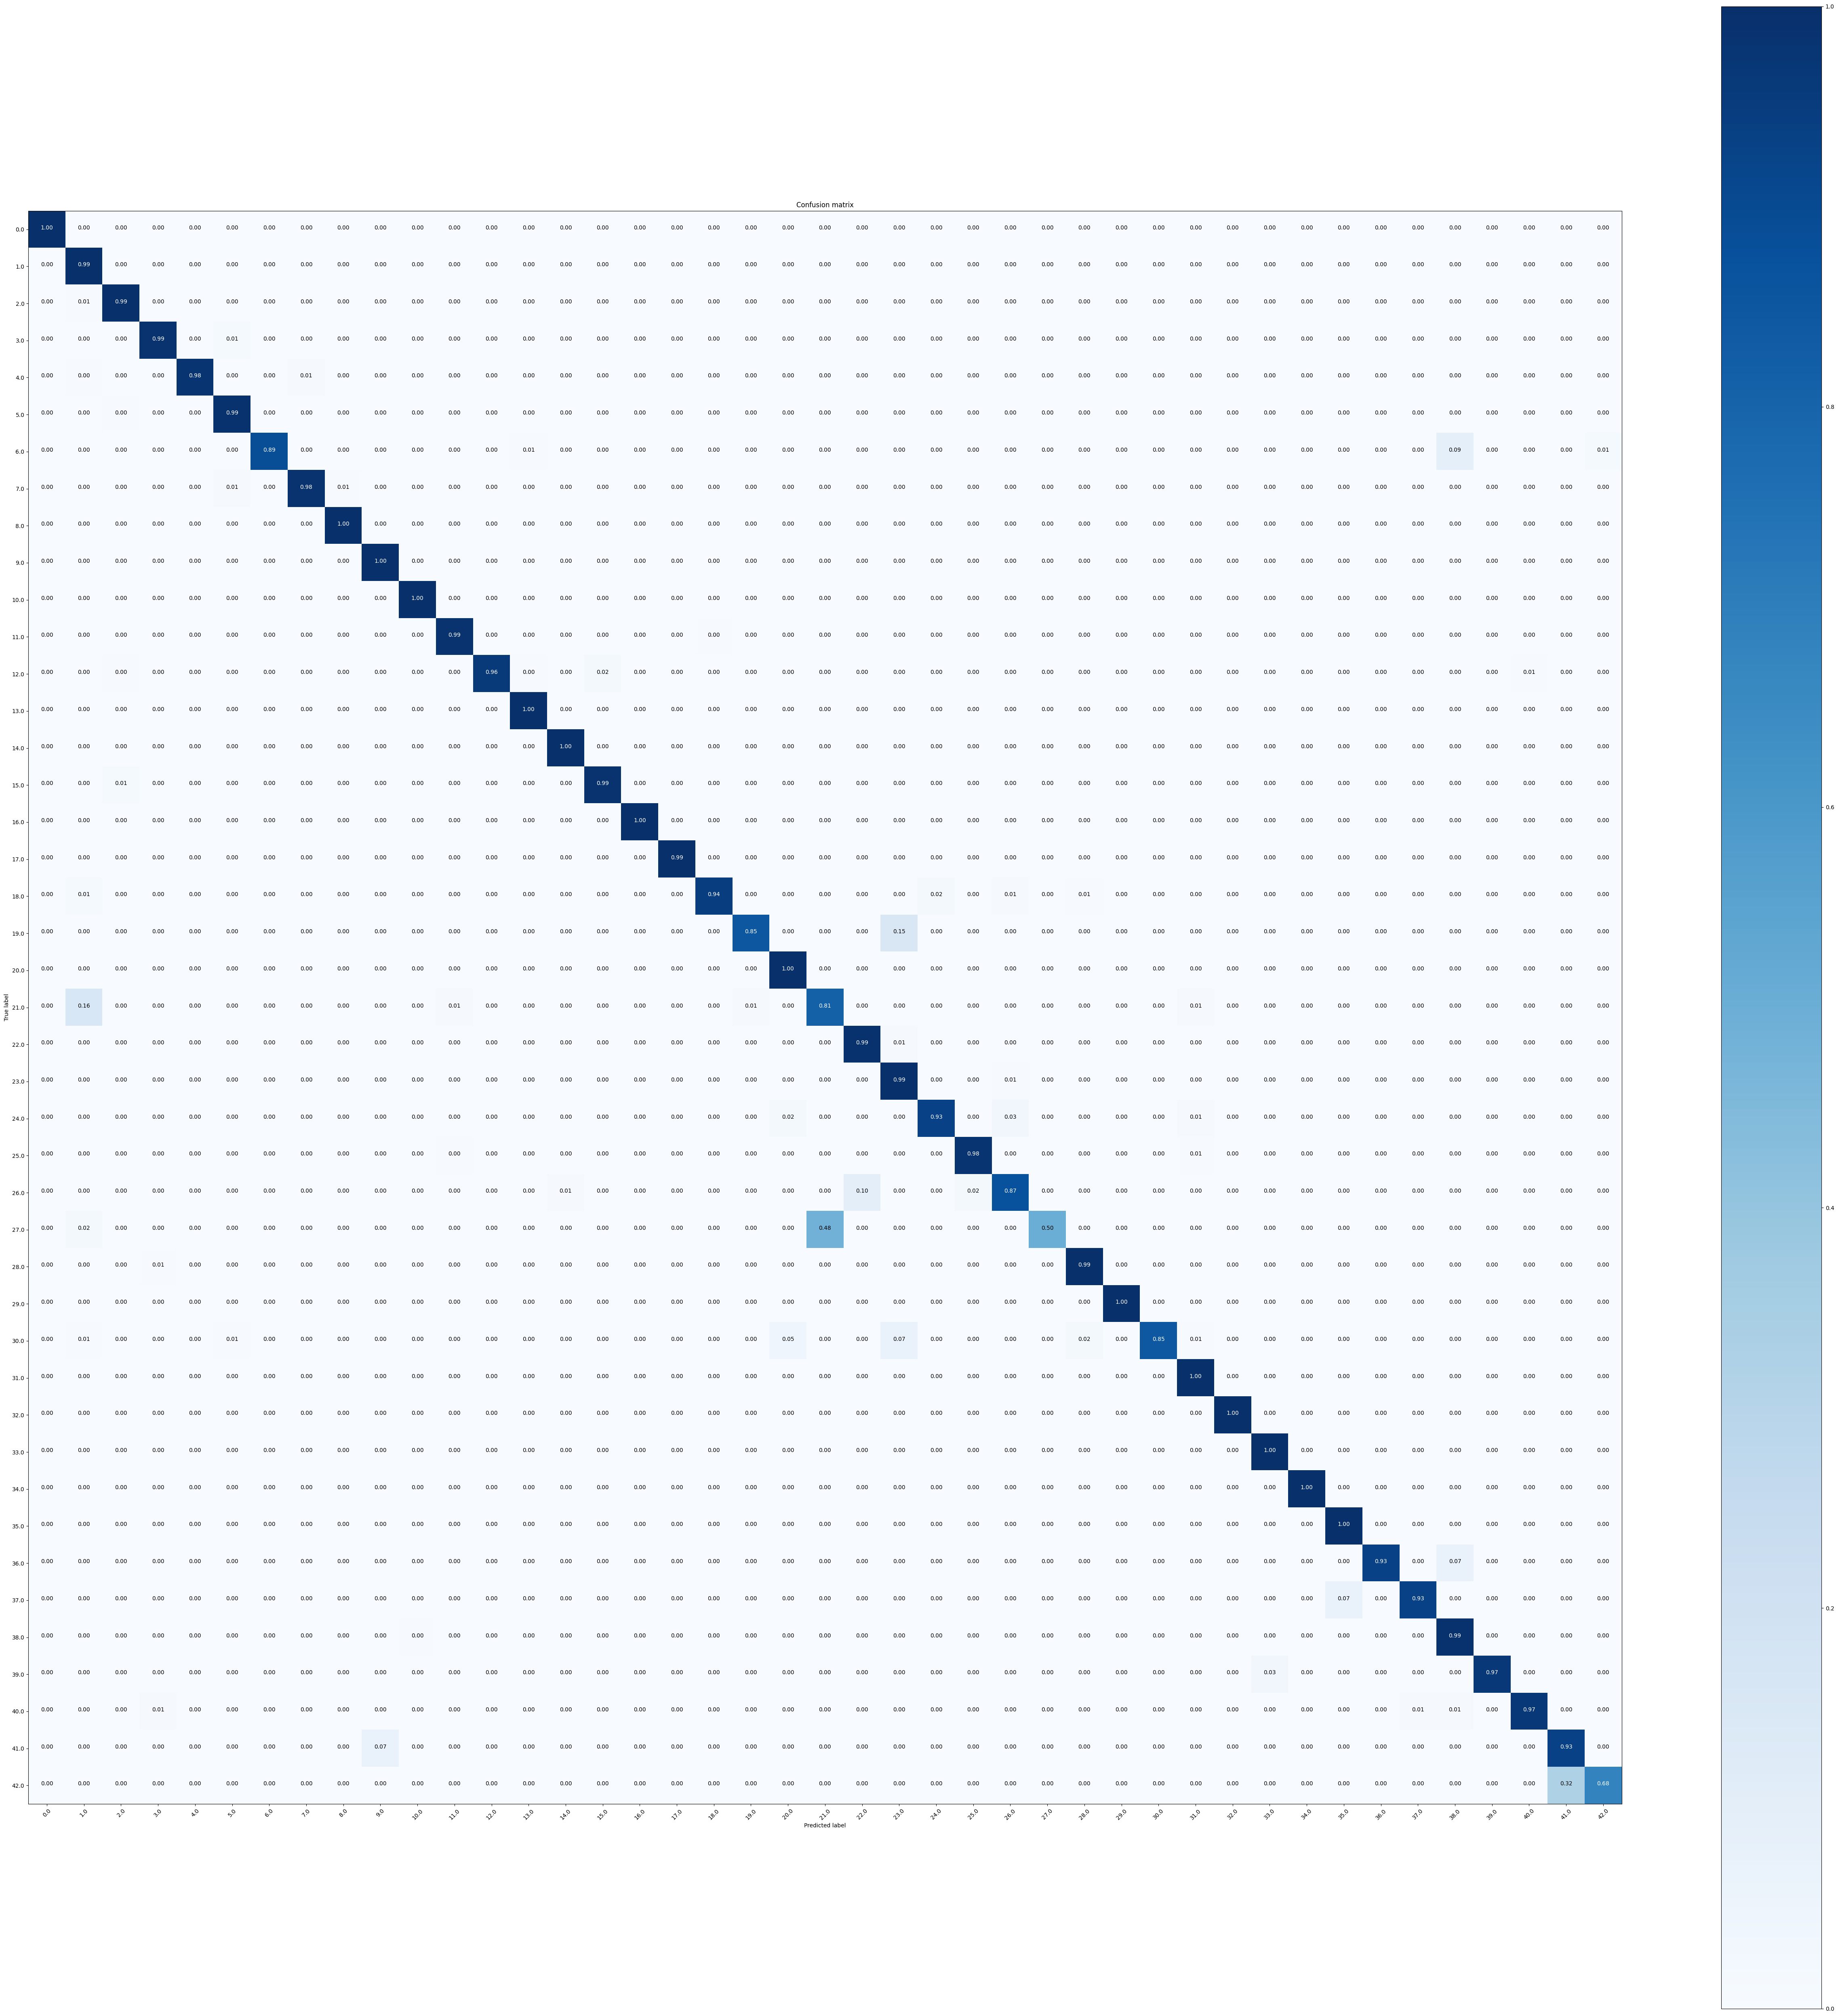

In [14]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_test, pred)
print(cf)
plot_confusion_matrix(cf,class_names)

Normalized confusion matrix


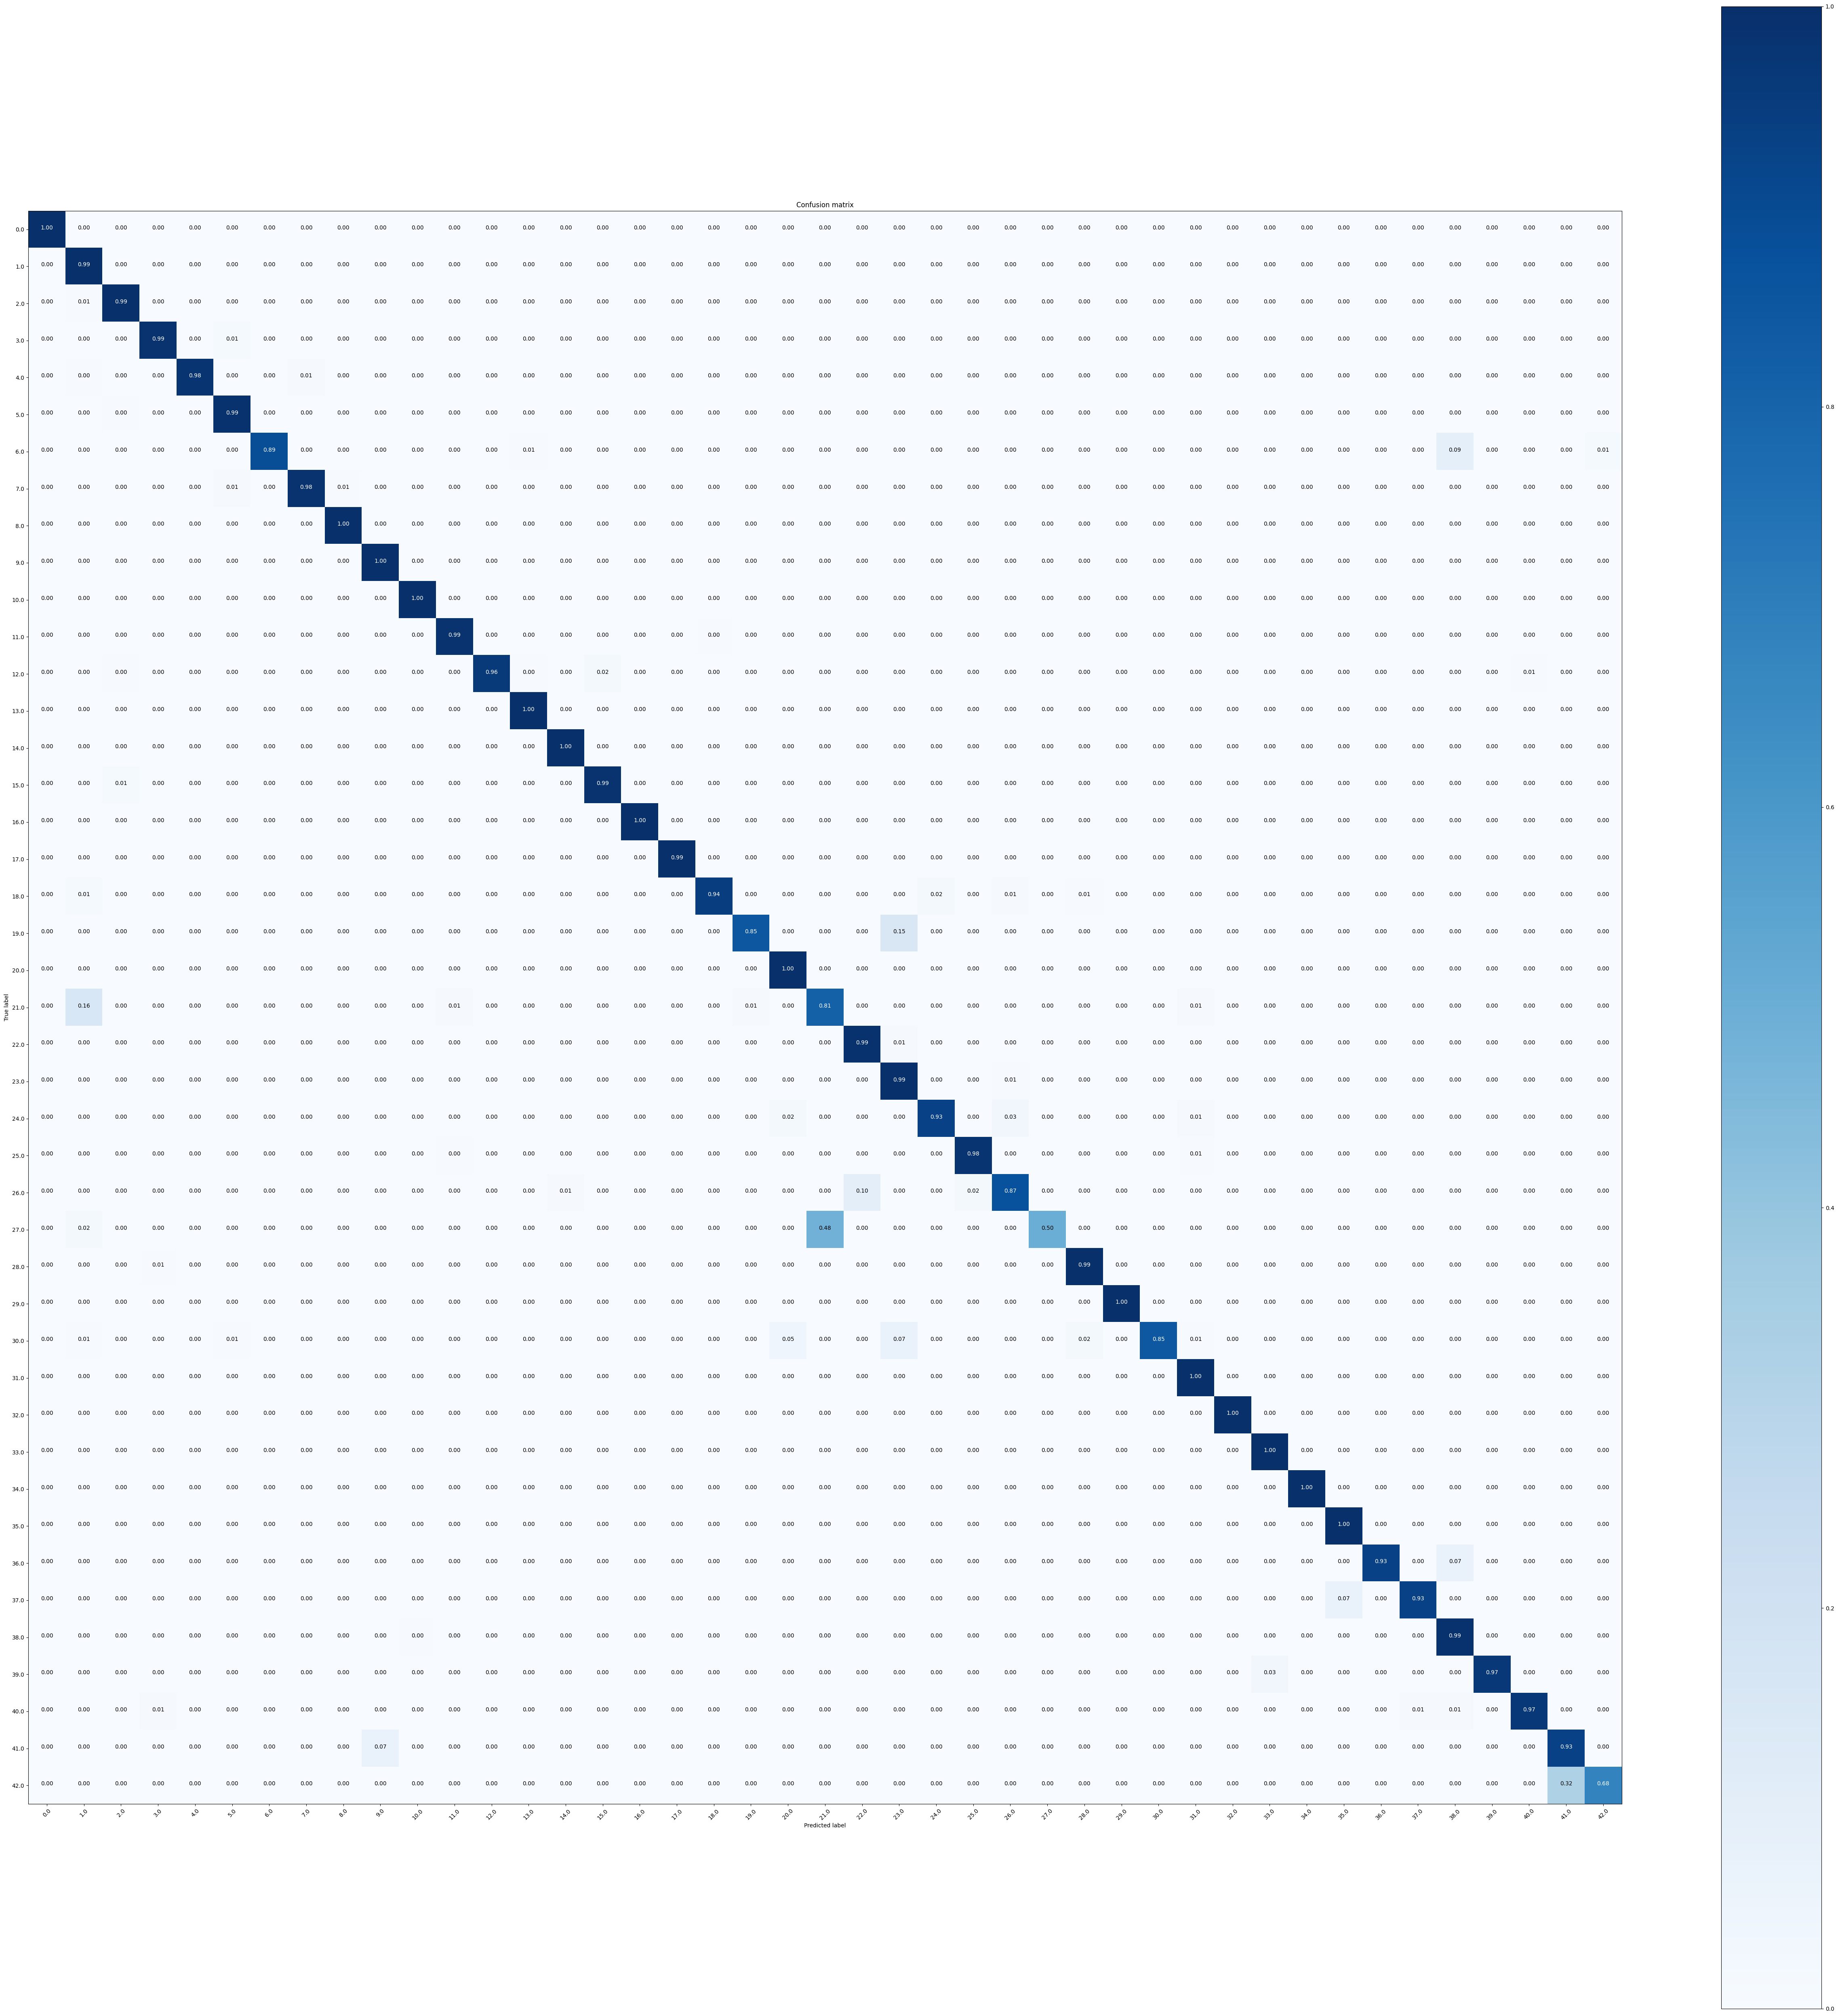

In [15]:
plot_confusion_matrix(cf,class_names )

<Axes: >

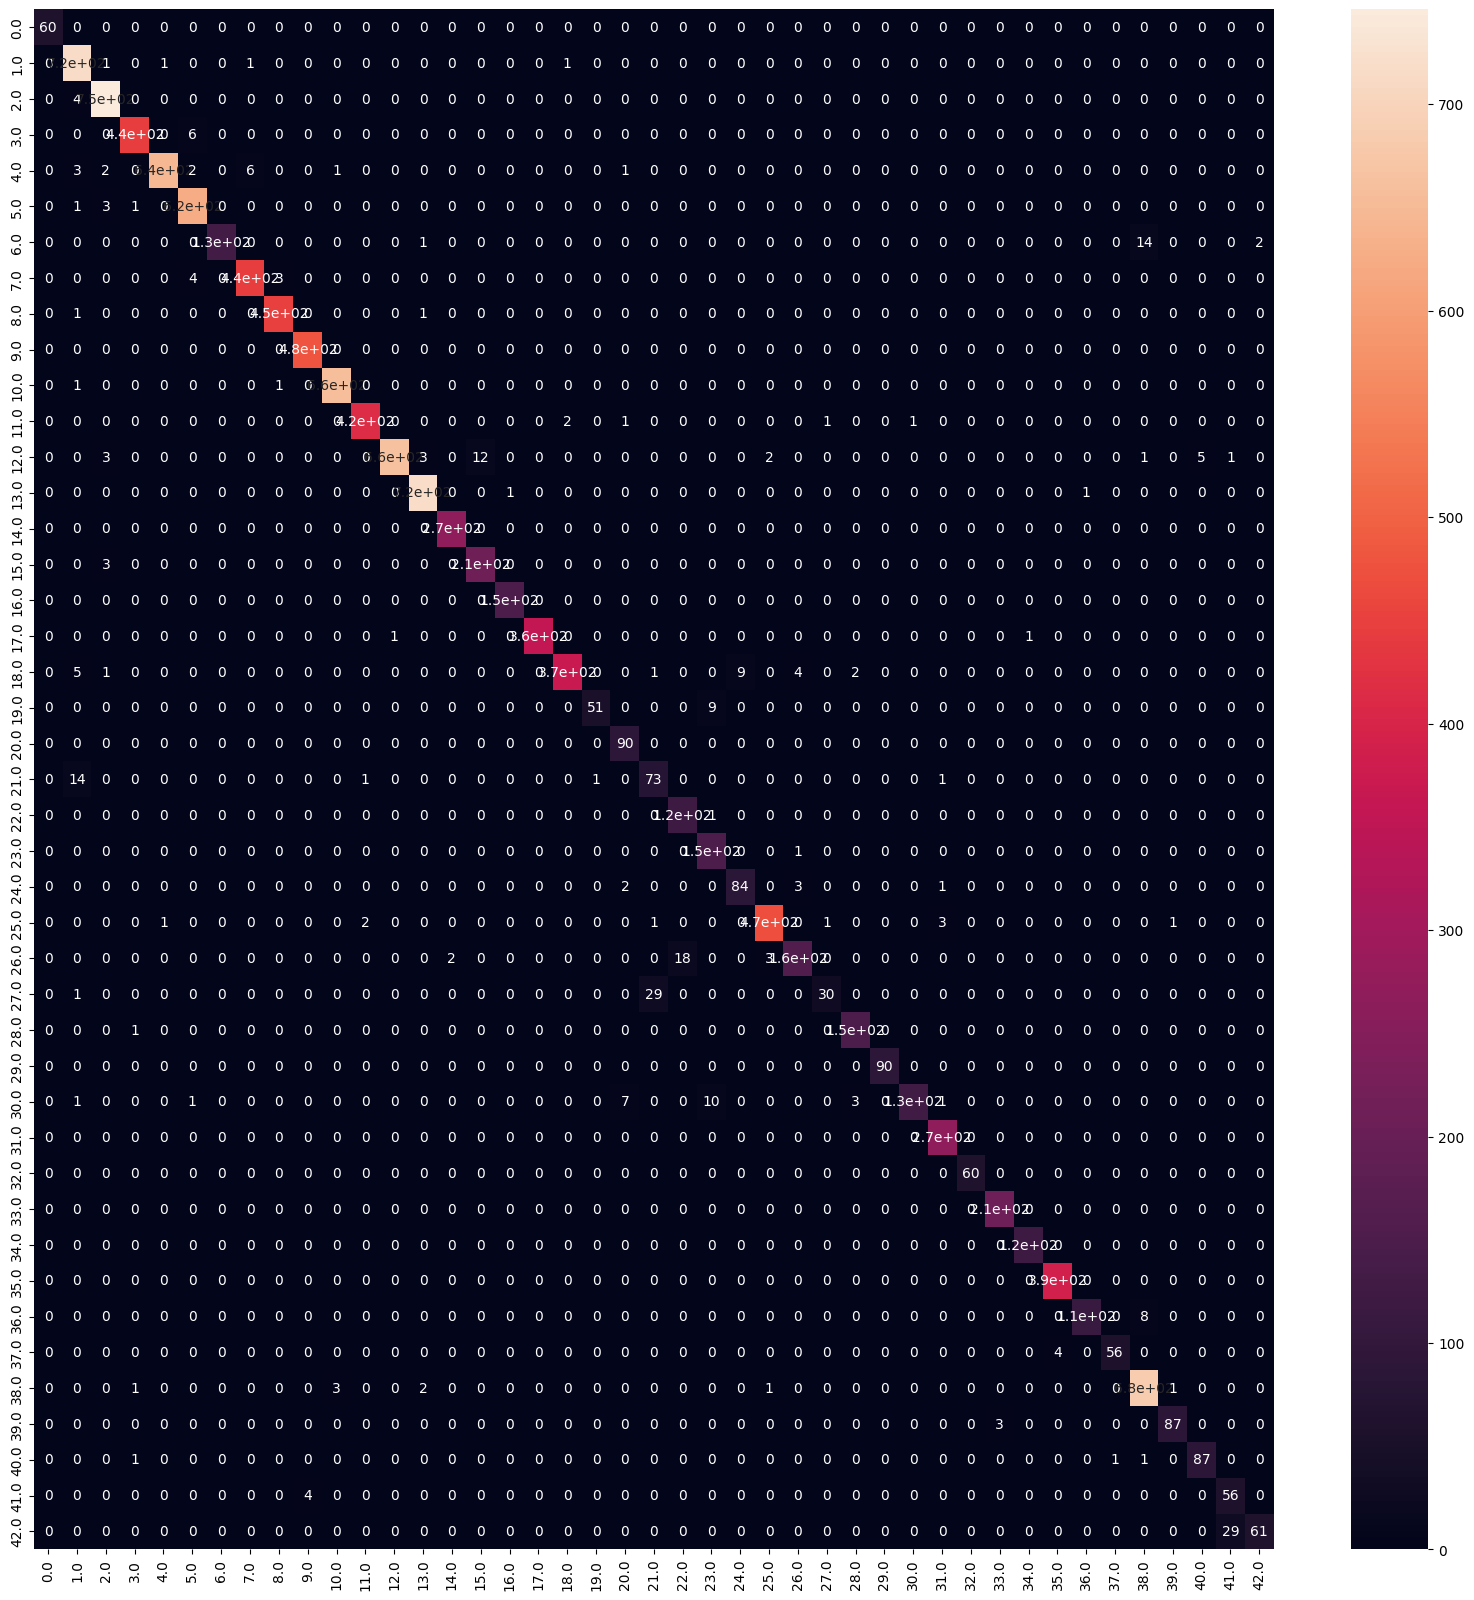

In [16]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = class_names,  columns = class_names)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

In [17]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.96      0.99      0.98       720
           2       0.98      0.99      0.99       750
           3       0.99      0.99      0.99       450
           4       1.00      0.98      0.99       660
           5       0.98      0.99      0.99       630
           6       1.00      0.89      0.94       150
           7       0.98      0.98      0.98       450
           8       0.99      1.00      0.99       450
           9       0.99      1.00      1.00       480
          10       0.99      1.00      1.00       660
          11       0.99      0.99      0.99       420
          12       1.00      0.96      0.98       690
          13       0.99      1.00      0.99       720
          14       0.99      1.00      1.00       270
          15       0.95      0.99      0.97       210
          16       0.99      1.00      1.00       150
          17       1.00    